In [1]:
import timm
import torch
from torch import nn

from vae import VAE
from loss import VAELoss , FocalLoss
import gymnasium as gym
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import ale_py
import random
import torch
from torchvision import transforms
import numpy as np
from PIL import Image , ImageFilter
import torch.nn.functional as F
import matplotlib.pyplot as plt

gym.register_envs(ale_py)

ENV_NAME = "PongNoFrameskip-v4"
TOTAL_TIMESTEPS = 1_000_000
MODEL_PATH = "ppo_pong"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


BATCH_SIZE = 8
ALLOWED_ACTIONS = [0, 2, 3]
action_to_index = {a: i for i, a in enumerate(ALLOWED_ACTIONS)}

vae = VAE(
    (1,80,80),
    latent_size=16,
    feature_sizes= [64]
).to(DEVICE)
loss = VAELoss()
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-4)

torch.compile(vae)

vae.train()

# Define transforms
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
])

mask_transform =  transforms.Compose([
    transforms.Lambda(lambda x: (x > 0.5).float())
])

env = make_atari_env(ENV_NAME, n_envs=1)
env.reset()

obs_stack = []


/home/ben/Documents/Courses/Spring-2025/Final/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


In [ ]:
import os
import numpy as np
from PIL import Image
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

#    
ENV_NAME = "PongNoFrameskip-v4"
MODEL_PATH = "./ppo_pong"
TOTAL_TIMESTEPS = 10000
SAVE_DIR = "./dataset_unbaised/"
os.makedirs(SAVE_DIR, exist_ok=True)

def train_until_zero_avg_reward():
    env = make_atari_env(ENV_NAME, n_envs=1, seed=0)
    env = VecFrameStack(env, n_stack=4)

    if os.path.exists(MODEL_PATH + ".zip"):
        model = PPO.load(MODEL_PATH, env=env)
    else:
        model = PPO("CnnPolicy", env, verbose=1)

    mean_reward = -np.inf
    while mean_reward < 0:
        model.learn(total_timesteps=TOTAL_TIMESTEPS, reset_num_timesteps=False)
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
        print(f"Average reward over 10 episodes: {mean_reward:.2f}")

    model.save(MODEL_PATH)
    env.close()
    return model

def generate_dataset(model):
    env = make_atari_env(ENV_NAME, n_envs=1, seed=42)
    env = VecFrameStack(env, n_stack=1)
    obs = env.reset()

    for s in range(TOTAL_TIMESTEPS):
        action, _ = model.predict(obs)
        obs, _, dones, _ = env.step(action)

        # Extract the most recent frame from the 4-frame stack (shape: [4, 84, 84])
        frame = obs[0]  # Take the last frame in the stack
        img = Image.fromarray(frame.astype(np.uint8), mode='L')
        img.save(os.path.join(SAVE_DIR, f"frame_{s:05d}.png"))

        if dones[0]:
            obs = env.reset()

    env.close()
    print(f"Saved {TOTAL_TIMESTEPS} frames to {SAVE_DIR}")

# Run everything
# model = train_until_zero_avg_reward()
# generate_dataset(model)


In [9]:
model = PPO.load(MODEL_PATH)
generate_dataset(model)

ValueError: Error: Unexpected observation shape (4, 84, 84, 1) for Box environment, please use (4, 84, 84) or (n_env, 4, 84, 84) for the observation shape.

In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms

# Constants
TOTAL_TIMESTEPS = 10000
ALLOWED_ACTIONS = [0, 1, 2, 3]  # Example actions; replace with your env's actions
SAVE_DIR = "./vae_dataset/"
os.makedirs(SAVE_DIR, exist_ok=True)

# Transform for preprocessing, if needed
transform = transforms.Compose([
    transforms.ToTensor()
])

# Initialize env
obs = env.reset()

for s in range(TOTAL_TIMESTEPS):
    # Choose a random action
    action = [random.choice(ALLOWED_ACTIONS)]
    obs, reward, done, info = env.step(action)

    # Convert observation to grayscale image and save
    img = Image.fromarray(obs[0].squeeze(-1))  # Adjust based on env output shape
    img.save(os.path.join(SAVE_DIR, f"frame_{s:05d}.png"))

    if done:
        env.reset()

print(f"Saved {TOTAL_TIMESTEPS} frames to {SAVE_DIR}")


Saved 10000 frames to ./vae_dataset/


In [ ]:
def visualize_reconstruction(sample_images, recon_samples, num_samples=1):
    vae.eval()
    with torch.no_grad():
        num_samples = min(num_samples, len(sample_images))

        # Handle subplot shape based on sample count
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))

        # If num_samples == 1, axes will not be a 2D array
        if num_samples == 1:
            axes = axes[:, None]  # Convert to 2D array for consistency

        for i in range(num_samples):
            # Original
            img = sample_images[i].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(img,cmap = "Greys")
            axes[0, i].axis('off')
            axes[0, i].set_title('Original' if i == 0 else '')

            # Reconstruction
            recon = recon_samples[i].cpu().permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon, cmap = "Greys")
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstruction' if i == 0 else '')

        plt.tight_layout()
        plt.show()


def save_checkpoint(state, filename='vae_checkpoint.pth'):
    torch.save(state, filename)
    print(f"Checkpoint saved to {filename}")

step: 7 Loss: 803.388671875


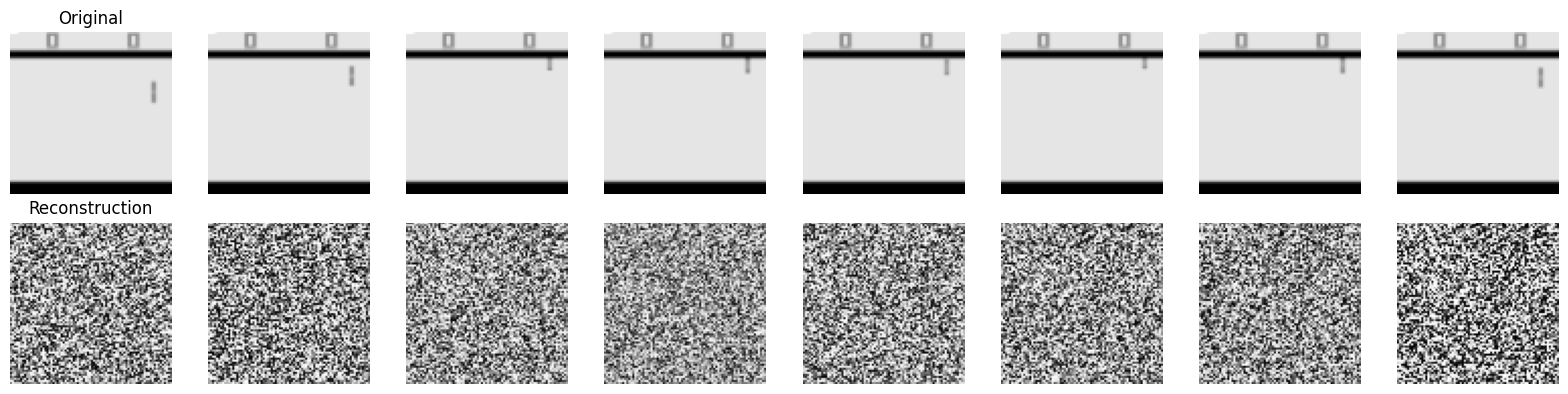

step: 4095 Loss: 37.87261199951172


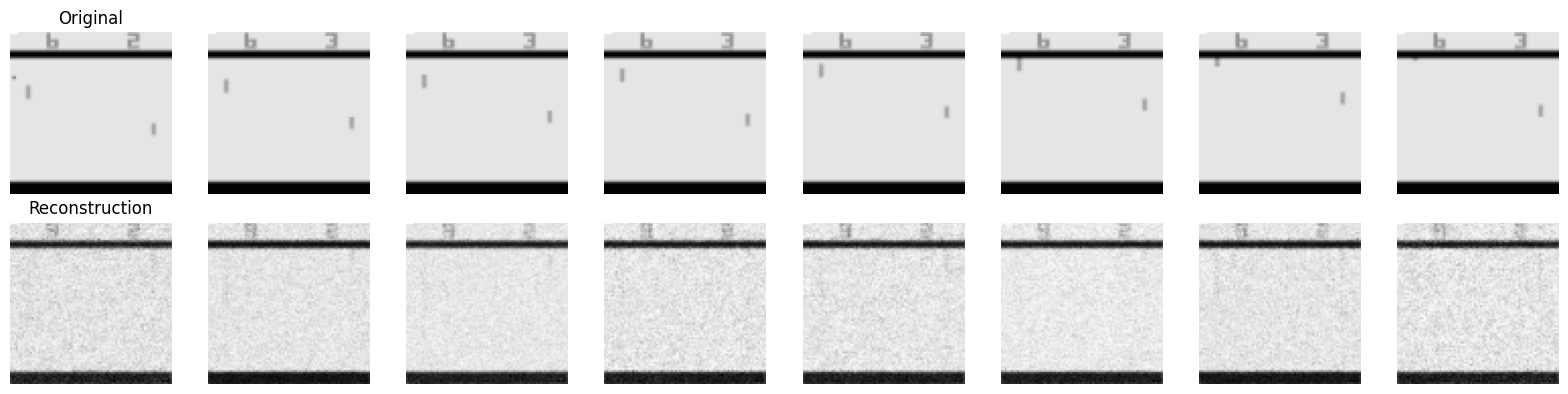

step: 8191 Loss: 32.27301788330078


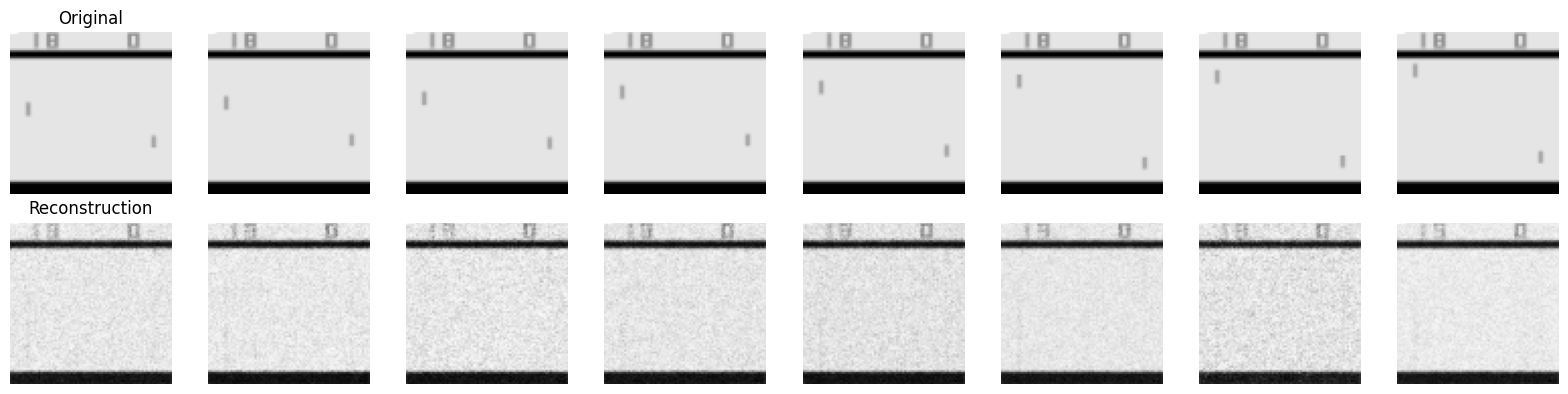

step: 12287 Loss: 28.630908966064453


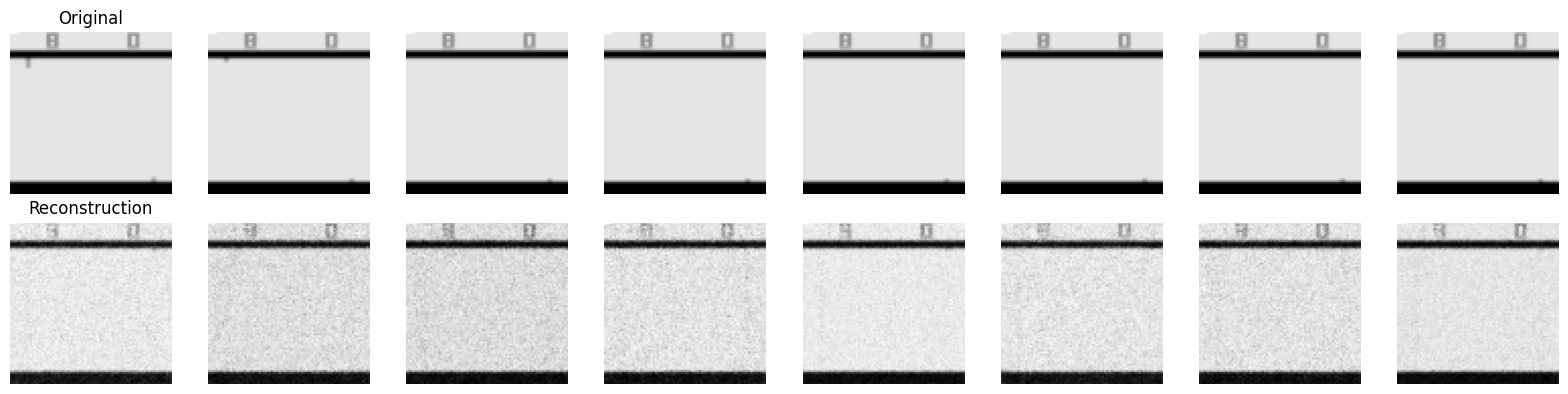

step: 16383 Loss: 21.351341247558594


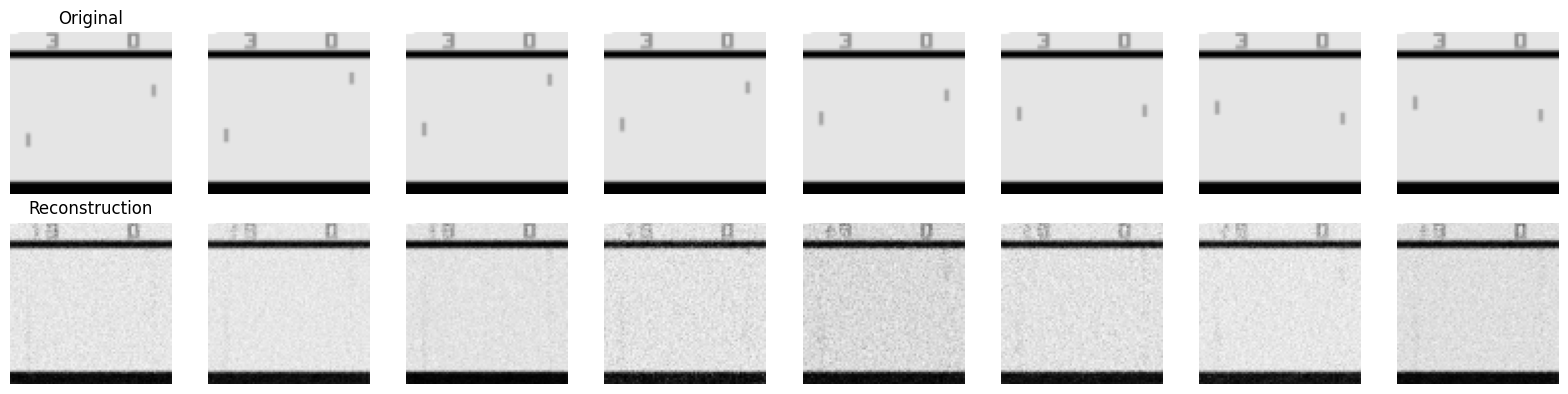

step: 20479 Loss: 16.006153106689453


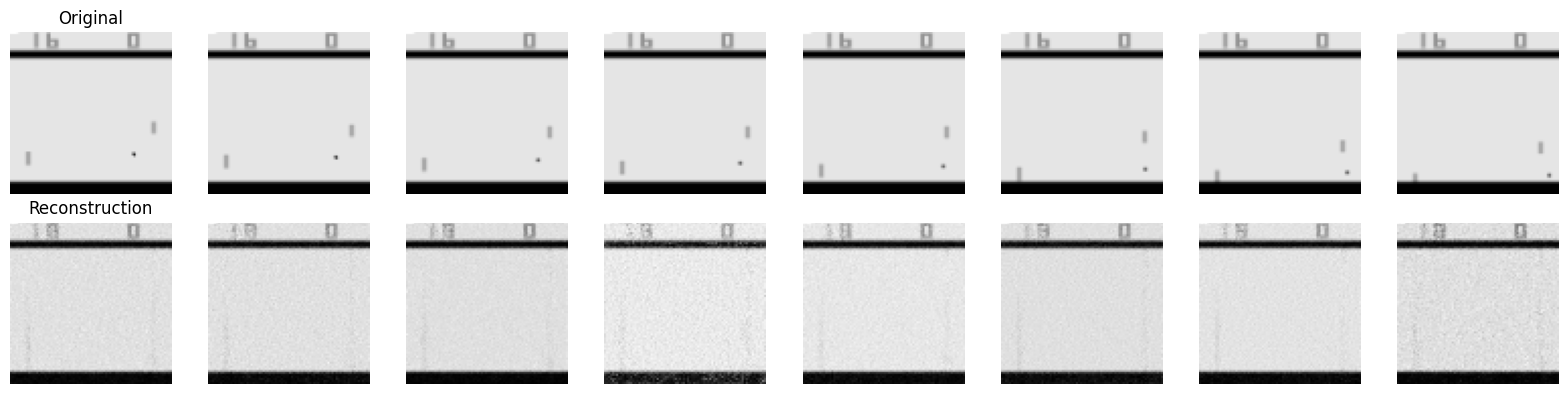

KeyboardInterrupt: 

In [ ]:
for s in range(TOTAL_TIMESTEPS):

    ## choose random action
    action = [random.choice(ALLOWED_ACTIONS)]
    obs, reward, done, info = env.step(action)

    img = Image.fromarray(obs[0].squeeze(-1))

    obs_stack.append(transform(img))

    if ((s+1) % BATCH_SIZE == 0):
        batch = torch.stack(obs_stack).to(DEVICE)

        optimizer.zero_grad()

        reconstructed_images, mean, log_var = vae(batch)
        total_loss, reconstructed_loss, kl_loss = loss(
            batch, reconstructed_images, mean, log_var,
        )

        # total_loss = loss(reconstructed_images,mask_transform(batch))

        if ((s+1)//BATCH_SIZE == 1 or (s+1) % 2**12 == 0):
            print(f"step: {s} Loss: {total_loss}")
            visualize_reconstruction(
            batch.detach().cpu(), 
            reconstructed_images.detach().cpu(),
            num_samples= min(BATCH_SIZE,8)
        )

        total_loss.backward()
        optimizer.step()

        obs_stack = []

    if done:
        env.reset()

## save model
